In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings("ignore")

In [2]:

# read the dataset as a data frame
df = pd.read_csv("/Users/silviagong/Downloads/movies.csv")

# drop NaN in column 'Rotten Tomatoes Rating' and 'IMDB Rating' so we can compare the ratings
df = df.dropna(subset=['Rotten Tomatoes Rating', 'IMDB Rating'])

# since the IMDB rating is out of 10, and Rotten Tomatoes is out of 100,
# we times IMDB Rating by 10
df['IMDB Rating'] = df['IMDB Rating'].apply(lambda x: x*10)

# Since the data has words as the release month, we replace the words by month numbers
def date_filter(d):
    d = d.replace("Jan","1").replace("Feb","2").replace("Mar","3").replace("Apr","4").replace("May","5").replace("Jun","6")
    d = d.replace("Jul","7").replace("Aug","8").replace("Sep","9").replace("Oct","10").replace("Nov","11").replace("Dec","12")
    return d

# filter Release Date into this format: "DD-MM-YY"
df['Release Date'] = df['Release Date'].apply(date_filter)
df = df.dropna(subset=["Release Date"])

# calculate the rating difference
def calculate_diff(row):
    return int(row['Rotten Tomatoes Rating']) - int(row['IMDB Rating'])

# new column recording the difference between Rotten Tomatoes Rating and IMDB Rating
df["RT-IMDB"] = df.apply(calculate_diff, axis=1)



In [3]:
# the ratings contain {'G', 'NC-17', 'Not Rated', 'Open', 'PG', 'PG-13', 'R'}
# filter out 'Not Rated', 'Open' and 'NC-17' (only has 1 datapoint) to drop them
def rating_filter(d):
    if d == "Not Rated" or d == "Open" or d == "NC-17":
        return None
    return d

# filter MPAA Rating
df["MPAA Rating"] = df["MPAA Rating"].apply(rating_filter)

# drop NaN for the MPAA Rating and store it in df_MPAA
# we have 1849 rows to work with in df_MPAA
df_MPAA = df.dropna(subset=["MPAA Rating"])


In [4]:
print("Average IMDB Rating is", sum(list(df['IMDB Rating']))/len(df))
print("Average Rotten Tomatoes Rating is",sum(list(df['Rotten Tomatoes Rating']))/len(df))

Average IMDB Rating is 63.08097345132743
Average Rotten Tomatoes Rating is 54.279646017699115


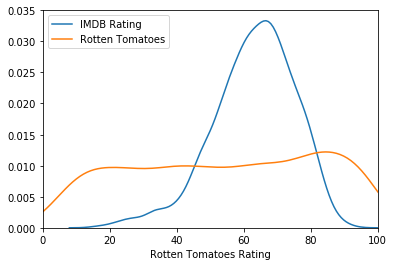

In [5]:
plt.xlim(0, 100)
sns.distplot(df['IMDB Rating'], label="IMDB Rating", hist=False)
sns.distplot(df['Rotten Tomatoes Rating'], label="Rotten Tomatoes", hist=False)

The rating difference in all movies shows that IMDB ratings are generally higher than the Rotten Tomatoes rating, with an average of 63.08 and 54.28 respectively.

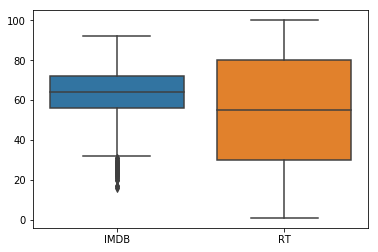

In [6]:
df_ratings = pd.DataFrame()
df_ratings["IMDB"] = df['IMDB Rating']
df_ratings["RT"] = df['Rotten Tomatoes Rating']

sns.boxplot(data=df_ratings)


In [7]:
median = np.median(df_ratings['IMDB'])
upper_quartile = np.percentile(df_ratings['IMDB'], 75)
lower_quartile = np.percentile(df_ratings['IMDB'], 25)
iqr = upper_quartile - lower_quartile

print("For IMDB Ratings:")
print("The lower quartile, median, upper quartile are", lower_quartile, median, upper_quartile)
print("The IQR is", iqr)
print()

median = np.median(df_ratings['RT'])
upper_quartile = np.percentile(df_ratings['RT'], 75)
lower_quartile = np.percentile(df_ratings['RT'], 25)
iqr = upper_quartile - lower_quartile

print("For Rotten Tomatoes Ratings:")
print("The lower quartile, median, upper quartile are", lower_quartile, median, upper_quartile)
print("The IQR is", iqr)

For IMDB Ratings:
The lower quartile, median, upper quartile are 56.0 64.0 72.0
The IQR is 16.0

For Rotten Tomatoes Ratings:
The lower quartile, median, upper quartile are 30.0 55.0 80.0
The IQR is 50.0


IMDB users tend to give more conservative ratings than the Rotten Tomatoes rating. The majority of their rating lies within 5.6 and 7.2, whereas the majority of Rotten Tomatoes rating lies within 30% and 80%.

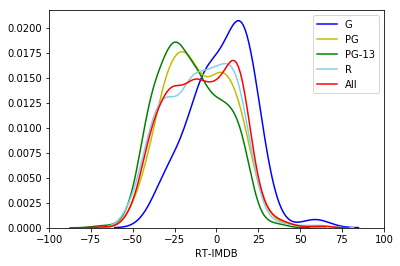

In [8]:
plt.xlim(-100, 100)
sns.distplot(df_MPAA.loc[df_MPAA['MPAA Rating'] == 'G']['RT-IMDB'], color="b", hist=False, label="G")
sns.distplot(df_MPAA.loc[df_MPAA['MPAA Rating'] == 'PG']['RT-IMDB'], color="y", hist=False, label="PG")
sns.distplot(df_MPAA.loc[df_MPAA['MPAA Rating'] == 'PG-13']['RT-IMDB'], color="g", hist=False, label="PG-13")
sns.distplot(df_MPAA.loc[df_MPAA['MPAA Rating'] == 'R']['RT-IMDB'], color="skyblue", hist=False, label="R")
sns.distplot(df['RT-IMDB'], color="r", hist=False, label="All")


As we can see, the rating difference in PG and R closely matches with the rating difference in all movies.

- For movies with rating G, Rotten Tomatoes users gives higher score on average.
- For movies with rating PG-13, Rotten Tomatoes users gives lower score on average.
- For movies with rating PG and R, Rotten Tomatoes and IMDB users give their typical scores that closely matches with the average scores they give to all moview.


In [9]:
# the US Gross and Worldwide Gross contain 0 as NaN, so we drop the 0s
# 5 movies have less than 10k Worldwide, so we filter them out as outliers
# then, we divide the number by 1,000,000 to make the numbers smaller
def gross_filter(d):
    if not d or not d.isdigit():
        return None
    if int(d) == 0 or int(d) < 10000:
        return None
    return int(d)/1000000

# filter Gross
df["US Gross"] = df["US Gross"].apply(gross_filter)
df["Worldwide Gross"] = df["Worldwide Gross"].apply(gross_filter)

# drop NaN for the Gross and store it in df_Gross
# we have 2237 rows to work with in df_Gross
df_Gross = df.dropna(subset=["US Gross", "Worldwide Gross"])


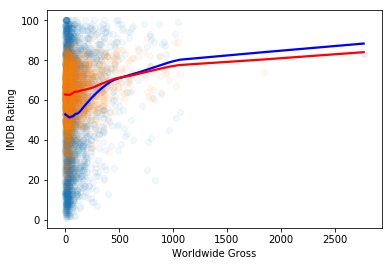

In [10]:
sns.regplot(x='Worldwide Gross', y='Rotten Tomatoes Rating', data=df_Gross, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'blue'})
sns.regplot(x='Worldwide Gross', y='IMDB Rating', data=df_Gross, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})


In [11]:
## Gross is in terms of millions!

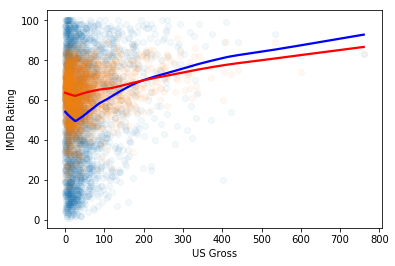

In [12]:
sns.regplot(x='US Gross', y='Rotten Tomatoes Rating', data=df_Gross, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'blue'})
sns.regplot(x='US Gross', y='IMDB Rating', data=df_Gross, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})


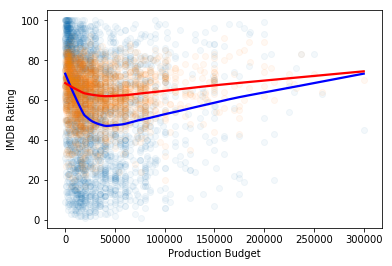

In [13]:
# Production Budget is in terms of thousands
df["Production Budget"] = df["Production Budget"].apply(lambda x:x/1000)
sns.regplot(x='Production Budget', y='Rotten Tomatoes Rating', data=df, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'blue'})
sns.regplot(x='Production Budget', y='IMDB Rating', data=df, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})


In [14]:
# filter out the date in the release year
for i, r in df.iterrows():
    date = r['Release Date']
    if not date: continue
    # account for data with only release years
    if date.find("-") == -1: 
        # filter out junk data
        if date.find("il") == 1: continue
        else: df.loc[i, 'Release_year'] = int(date)
        continue
    d,m,y = date.split("-")
    
    # make year into YYYY format instead of YY format for better comparison
    if int(y) > 10: y = int("19"+y)
    else: y = int("20"+y)
        
    df.loc[i, 'Release_year'] = y

# the range of the movies are from 1915 to 2010

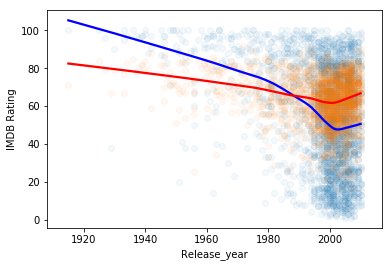

In [15]:
sns.regplot(x='Release_year', y='Rotten Tomatoes Rating', data=df, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'blue'})
sns.regplot(x='Release_year', y='IMDB Rating', data=df, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})


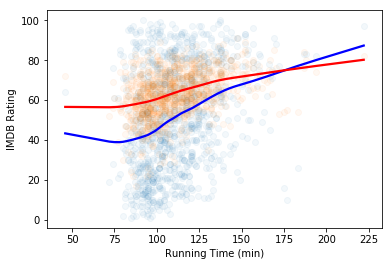

In [16]:
# analyze the movie runtime, have 983 data points
df_runtime = df.dropna(subset=["Running Time (min)"])
sns.regplot(x='Running Time (min)', y='Rotten Tomatoes Rating', data=df_runtime, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'blue'})
sns.regplot(x='Running Time (min)', y='IMDB Rating', data=df_runtime, lowess=True, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})
